## Import

In [1]:
%cd ./ai/open

/home/grdnr/ai/open


In [2]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from typing import List, Union
from joblib import Parallel, delayed

import segmentation_models_pytorch as smp
import argparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Utils

In [3]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom dataset

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Data Loader

In [ ]:
transform = A.Compose(
    [
        A.Resize(224, 224),
        A.CenterCrop(224, 224, p=0.7),

        #A.HorizontalFlip(p = 0.5),

        #A.IAAAdditiveGaussianNoise(p=0.2),
        #A.IAAPerspective(p=0.5),

        #A.OneOf([
            #A.CLAHE(p=1),
            #A.RandomBrightness(p = 1),
            #A.RandomGamma(p = 1)
        #], p = 0.5),

        #A.OneOf([
            #A.IAASharpen(p = 1),
            #A.Blur(blur_limit=3, p=1),
            #A.GaussianBlur(p = 1),
            #A.MotionBlur(blur_limit=3, p=1),
            #A.GaussNoise(p = 1)
        #], p = 0.5),

        #A.OneOf([
            #A.RandomContrast(p=1),
            #A.HueSaturationValue(p=1),
        #], p = 0.5),

        #A.Resize(224, 224),

        A.Normalize(),
        ToTensorV2()
    ]
)

transform_test = A.Compose(
    [
        A.Resize(224, 224),

        A.Normalize(),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
dataloader2 = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

test_dataset = SatelliteDataset(csv_file='test.csv', transform=transform_test, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

##Define Model

In [6]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

model1 = smp.Unet(
    encoder_name = ENCODER,
    encoder_weights = ENCODER_WEIGHTS,
    in_channels = 3,
    classes = 1,
    activation = ACTIVATION,
)

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

model2 = smp.Unet(
    encoder_name = ENCODER,
    encoder_weights = ENCODER_WEIGHTS,
    in_channels = 3,
    classes = 1,
    activation = ACTIVATION,
)

##Model Train

In [18]:
import segmentation_models_pytorch.utils

# loss function과 optimizer 정의
criterion = smp.utils.losses.DiceLoss()

optimizer = torch.optim.Adam([dict(params=model1.parameters(), lr=0.0001),])

# training loop
for epoch in range(20):  # 20 에폭 동안 학습합니다.
    model1.train()
    model1.to('cuda')
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

100%|█████████████████████████████████████████| 893/893 [04:43<00:00,  3.15it/s]


Epoch 1, Loss: 0.21785841062915284


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]


Epoch 2, Loss: 0.21025339112703637


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]


Epoch 3, Loss: 0.20316274302270085


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]


Epoch 4, Loss: 0.19867370109942564


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]


Epoch 5, Loss: 0.19361462331432244


100%|█████████████████████████████████████████| 893/893 [04:46<00:00,  3.12it/s]


Epoch 6, Loss: 0.1894934766103012


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.12it/s]


Epoch 7, Loss: 0.18560793144839074


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]


Epoch 8, Loss: 0.18285950801407236


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]


Epoch 9, Loss: 0.1797796230834115


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]


Epoch 10, Loss: 0.1767364642921781


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]


Epoch 11, Loss: 0.17400421734486288


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]


Epoch 12, Loss: 0.17130029261579438


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]


Epoch 13, Loss: 0.1693390598489349


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]


Epoch 14, Loss: 0.16706596630284393


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]


Epoch 15, Loss: 0.1649325760988746


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]


Epoch 16, Loss: 0.16233269191135352


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.12it/s]


Epoch 17, Loss: 0.16077110001114422


100%|█████████████████████████████████████████| 893/893 [04:47<00:00,  3.11it/s]


Epoch 18, Loss: 0.15871349207364432


100%|█████████████████████████████████████████| 893/893 [04:46<00:00,  3.12it/s]


Epoch 19, Loss: 0.15749215285428295


100%|█████████████████████████████████████████| 893/893 [04:45<00:00,  3.13it/s]

Epoch 20, Loss: 0.1553831253313404


In [19]:
# loss function과 optimizer 정의
optimizer = torch.optim.Adam([dict(params=model2.parameters(), lr=0.0001),])

# training loop
for epoch in range(20):  # 10 에폭 동안 학습합니다.
    model2.train()
    model2.to('cuda')
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.13it/s]


Epoch 1, Loss: 0.22351315240443487


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.12it/s]


Epoch 2, Loss: 0.214436210616839


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.12it/s]


Epoch 3, Loss: 0.20739604511026039


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.12it/s]


Epoch 4, Loss: 0.20046203507554758


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.12it/s]


Epoch 5, Loss: 0.19462340002230807


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.11it/s]


Epoch 6, Loss: 0.18868700801191512


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.11it/s]


Epoch 7, Loss: 0.18353773204636867


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.11it/s]


Epoch 8, Loss: 0.18048675102989992


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.11it/s]


Epoch 9, Loss: 0.17775803050161876


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.11it/s]


Epoch 10, Loss: 0.17326674429326416


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.10it/s]


Epoch 11, Loss: 0.16960890522729377


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.11it/s]


Epoch 12, Loss: 0.1657246244447629


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.10it/s]


Epoch 13, Loss: 0.16325580272802714


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.11it/s]


Epoch 14, Loss: 0.16039972636360605


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.11it/s]


Epoch 15, Loss: 0.15799267888736618


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.11it/s]


Epoch 16, Loss: 0.15587216008283522


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.11it/s]


Epoch 17, Loss: 0.1531863884722933


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.12it/s]


Epoch 18, Loss: 0.1514998344664878


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.11it/s]


Epoch 19, Loss: 0.1495435024963114


100%|█████████████████████████████████████████| 893/893 [02:05<00:00,  7.13it/s]

Epoch 20, Loss: 0.14736324268385917


In [20]:
torch.save(model.state_dict(), 'weights_only.pth')

NameError: name 'model' is not defined

In [ ]:
model.load_state_dict(torch.load('weights_only.pth'))

##Inference

In [21]:
test_dataset = SatelliteDataset(csv_file='test.csv', transform=transform_test, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [22]:
with torch.no_grad():
    model1.eval()
    model2.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs1 = model1(images)
        masks1 = outputs1.cpu().numpy()
        masks1 = np.squeeze(masks1, axis=1)
        outputs2 = model2(images)
        masks2 = outputs2.cpu().numpy()
        masks2 = np.squeeze(masks2, axis=1)
        
        ensemble_preds = masks1*0.6 + masks2*0.4
        ensemble_preds = (ensemble_preds > 0.35).astype(np.uint8) # Threshold = 0.35

        for i in range(len(images)):
            mask_rle = rle_encode(ensemble_preds[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

100%|███████████████████████████████████████| 3790/3790 [13:55<00:00,  4.53it/s]


##Submission

In [23]:
submit = pd.read_csv('sample_submission.csv')
submit['mask_rle'] = result

In [24]:
submit.to_csv('ensemble.csv', index=False)

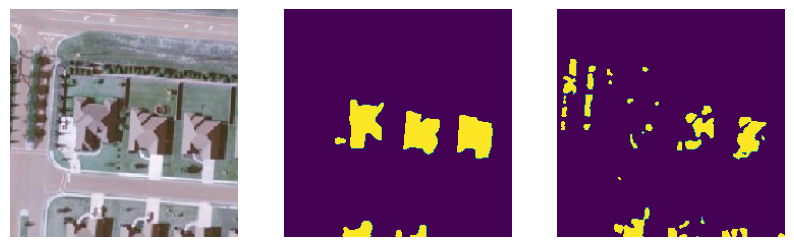

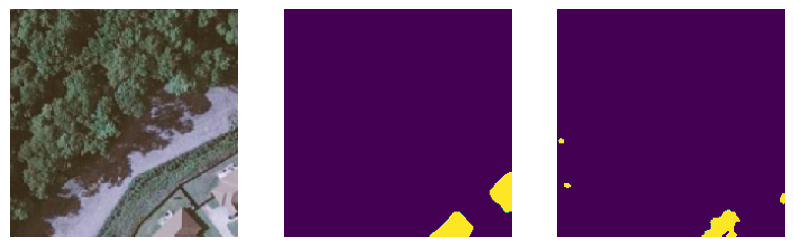

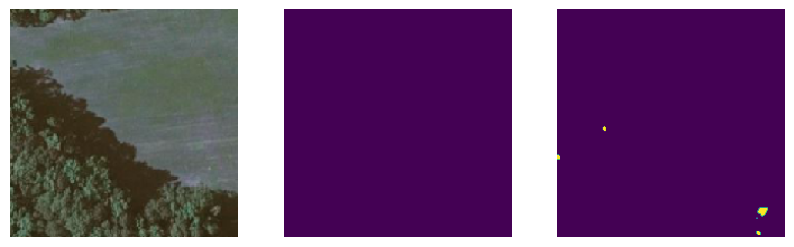

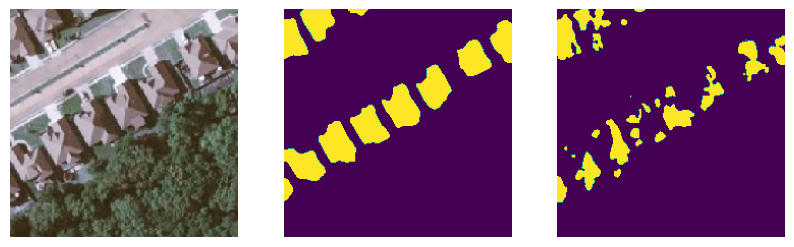

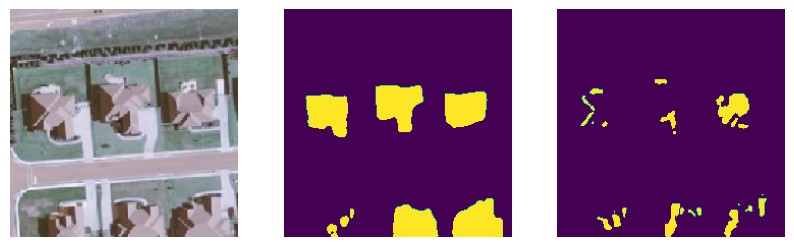

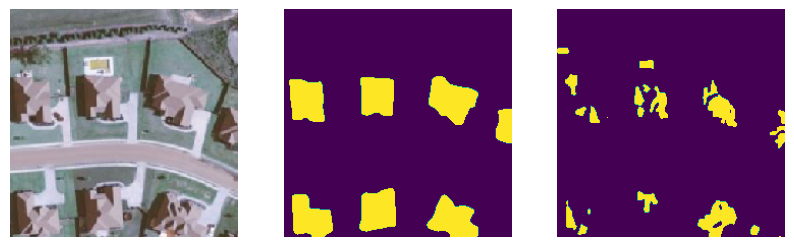

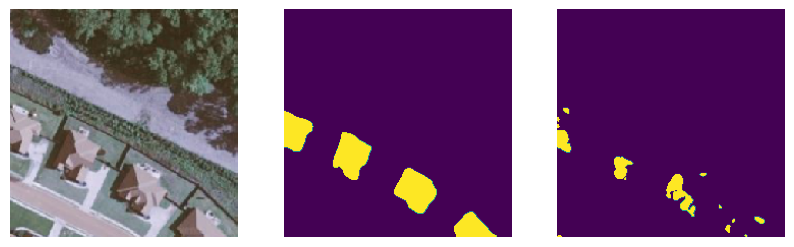

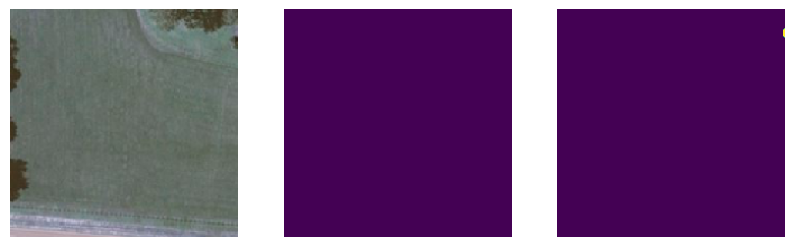

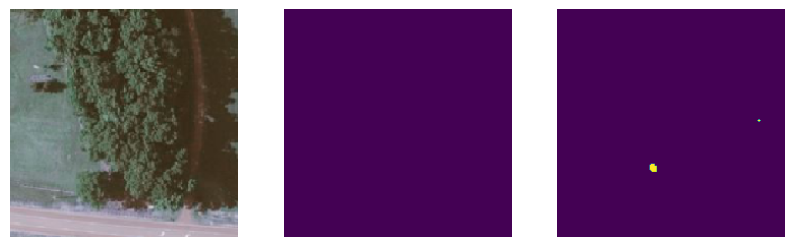

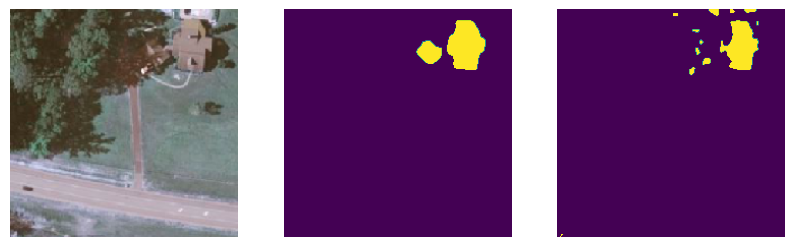

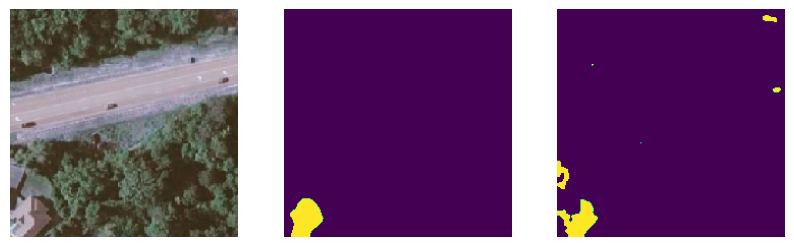

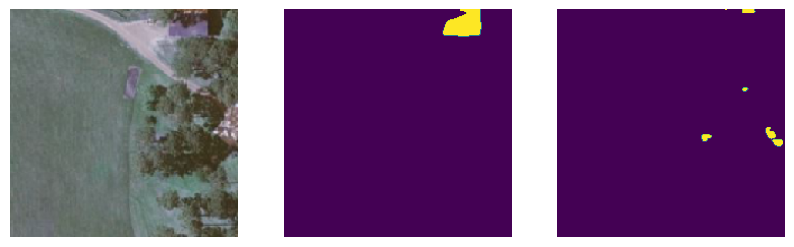

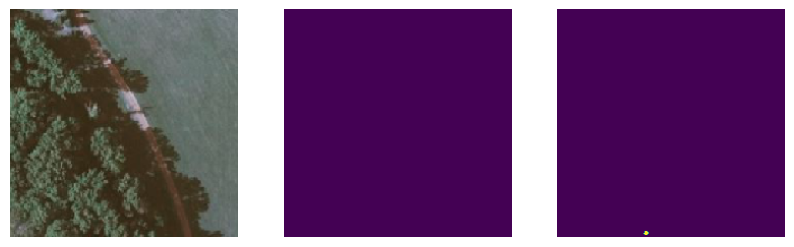

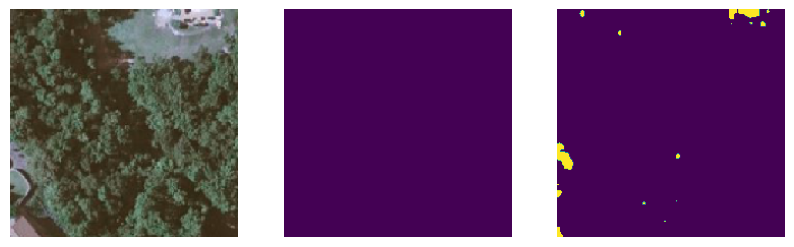

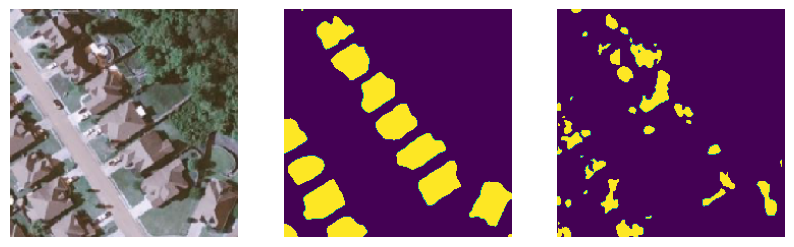

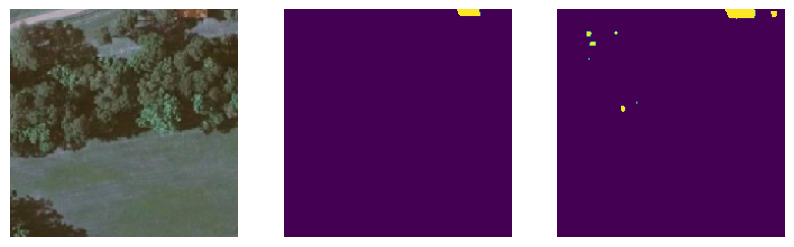

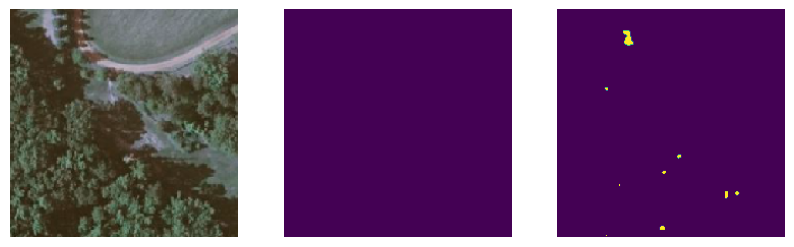

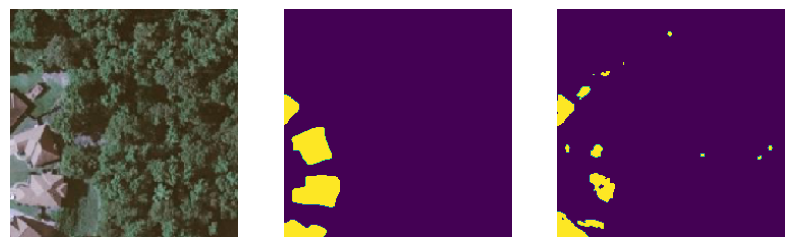

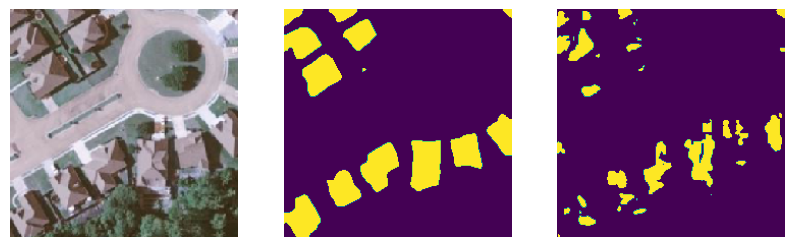

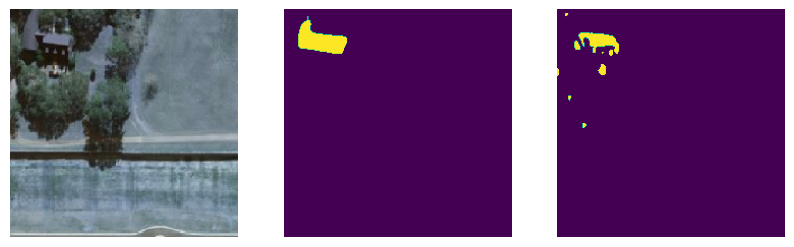

In [25]:
test_data = pd.read_csv('test.csv')
submit1 = pd.read_csv('epoch20_efficient_dice.csv')
submit2 = pd.read_csv('ensemble.csv')

import matplotlib.pyplot as plt

for i in range(20):
    test_image_path = test_data['img_path'][i]
    test_image = cv2.imread(test_image_path)
    test_mask1 = rle_decode(submit1['mask_rle'][i], (224,224))
    test_mask2 = rle_decode(submit2['mask_rle'][i], (224,224))

    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.imshow(test_image)
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(test_mask1)
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(test_mask2)
    plt.axis("off")